# Corona - German mortality and vaccination timeseries

## Data sources:

1. Mortality statistics for the years 2000 to 2015: [de_statis: Deutschland Sterbefälle 2000-2015](https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Sterbefaelle-Lebenserwartung/Tabellen/sonderauswertung-sterbefaelle-endgueltige-daten.html;jsessionid=7C42BA66C2036FF4141E5AC46AD386D5.live712?nn=209016)
2. Mortality statistics for the years 2016 to 2022 (Aug 21): [de_statis: Deutschland Sterbefälle 2016-2022 ](https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Sterbefaelle-Lebenserwartung/Tabellen/sonderauswertung-sterbefaelle.html)
3. Vaccination statistics from 2020 onwards: [impfdashboard.de - Daten zum Downlad](https://impfdashboard.de/daten)


rough outline of the next steps:

1. import the mortality data as a continuous week based time series beginning with the first week of 2010 as index week 1
    - import the data based on maximum granularity regarding sex and age group
    - compose aggregating views 
    - 


2. import the vaccination data as continuous week based time series
    - get acquainted with the data model
    - see from there
    

3. go and find people already doing analysis on the data, esp. 
    - go and explain this finding: [Starker (negativer) statistischer Zusammenhang zwischen der Covid-19-Impfquote und der Übersterblichkeit](https://idw-online.de/de/news786629)
    - German statistics computes excess mortality as the difference between the median value for the same timeframes of the four previous years: [WHO-Studie zur Corona-Übersterblichkeit nutzt störanfällige Methode](https://www.rwi-essen.de/presse/wissenschaftskommunikation/unstatistik/detail/who-studie-zur-corona-uebersterblichkeit-nutzt-stoeranfaellige-methode)




In [28]:
# import requirements

import pandas as pd
import pprint
import statistics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure as fig
#import seaborn as sns
#sns.set_theme(style="darkgrid")

In [29]:
# import mortality data and calculate excess and change

sterbefaelle = pd.read_csv('../data/deaths/sterbefaelle-2010-2022-je-woche.csv', delimiter=';')

# calculate excess mortality per week following the difference between actual data point 
# and "median of the four prior corresponding data points" methond of  de_statis

i = 0
for x in sterbefaelle.iterrows():    
    sterbefaelle.iloc[3,10]
    if sterbefaelle.loc[i,"week_index"] >= 209:
        sterbefaelle.loc[i,"total_median"] = statistics.median([sterbefaelle["total"][i-208],sterbefaelle["total"][i-156],sterbefaelle["total"][i-104],sterbefaelle["total"][i-52]])
        sterbefaelle.loc[i,"total_excess"] = sterbefaelle["total"][i] - sterbefaelle["total_median"][i]   
    else:
        sterbefaelle["total_median"] = 0
        sterbefaelle["total_excess"] = 0
        
    if sterbefaelle.loc[i,"week_index"] >= 210:  
        sterbefaelle.loc[i,"change_median"]       = 1 - (sterbefaelle["total_median"][i]/sterbefaelle["total_median"][i-1])  
        sterbefaelle.loc[i,"change_excess"]       = 1 - (sterbefaelle["total_excess"][i]/sterbefaelle["total_excess"][i-1])
    else: 
        sterbefaelle.loc[i,"change_median"] = 0
        sterbefaelle.loc[i,"change_excess"] = 0
    
    i = i+1


In [58]:
# import vaccination data 

vaccinations = pd.read_csv('../data/vaccinations/germany_vaccinations_timeseries_v3.tsv', sep='\t')
#vaccinations
vax_columns = [
    'week_index',       # added preemptively for the next step of aggregating data on a weekly basis
    'impfungen',
    'impfungen_biontech',
    'impfungen_biontech_min1',
    'impfungen_biontech_gi',
    'impfungen_biontech_boost1',
    'impfungen_biontech_boost2',
    'impfungen_moderna',
    'impfungen_moderna_min1',
    'impfungen_moderna_gi',
    'impfungen_moderna_boost1',
    'impfungen_moderna_boost2',
    'impfungen_astra',
    'impfungen_astra_min1',
    'impfungen_astra_gi',
    'impfungen_astra_boost1',
    'impfungen_astra_boost2',
    'impfungen_johnson',
    'impfungen_johnson_min1',
    'impfungen_johnson_gi',
    'impfungen_johnson_boost1',
    'impfungen_johnson_boost2',
    'impfungen_novavax',
    'impfungen_novavax_min1',
    'impfungen_novavax_gi',
    'impfungen_novavax_boost1',
    'impfungen_novavax_boost2',
    'personen_min1',
    'impfungen_min1',
    'personen_gi',
    'impfungen_gi',
    'personen_boost1',
    'impfungen_boost1',
    'personen_boost2',
    'impfungen_boost2',
    ]


In [97]:
# extract data from mortality and vaccination sources for the identical timeframe
# the mortality data date range ends with the week from 15th to 21st of August 2022
# this is 86 weeks overlap with the vaccination data.
# For conversion to weekly data the 1st through 602nd rows of the dataframe are grouped


# 1. convert vaccination data to weekly

i = 0
j = 573

for row in vaccinations.iterrows():
    vaccinations.loc[i,"day_index"] = i
    vaccinations.loc[i,"week_index"] = j
    i = i+1
    if i % 7 == 1:
        j = j+1

vax_weekly = vaccinations[vax_columns][1:602].groupby(by="week_index").sum()
vax_weekly.reindex(columns=["week_index","impfungen","impfungen_lag"])



# 2. extract the corresponding part from the mortality data

deaths_list = ["week_index", "monday", "total", "total_excess"]
deaths_weekly = sterbefaelle[deaths_list]
#print(deaths_weekly)


# 3. merge the timeseries to one dataframe. 
# Merge using the default method of inner join.

death_vax_weekly = deaths_weekly.merge(vax_weekly, left_on='week_index', right_on='week_index')#, how='left')
#print(death_vax_weekly)


# 4. create additional variables for combined first and second shots of Pfizer / Biontech
# combined first and second shots of Pfizer / Biontech:
death_vax_weekly["impfungen_biontech_min1_gi"] = (death_vax_weekly["impfungen_biontech_min1"] + death_vax_weekly["impfungen_biontech_gi"])


# 4. calculate the z-scores of the variables "total deaths", "total excess deaths" and "vaccinations (impfungen)"
z_score_list   = ["total","total_excess","impfungen","impfungen_biontech_min1_gi"]
total_mean = death_vax_weekly[z_score_list].mean()
total_std  = death_vax_weekly[z_score_list].std()
death_vax_weekly["total_z"]     = (death_vax_weekly["total"]-total_mean[0])/total_std[0]
death_vax_weekly["total_excess_z"]    = (death_vax_weekly["total_excess"]-total_mean[1])/total_std[1]
death_vax_weekly["impfungen_z"] = (death_vax_weekly["impfungen"]-total_mean[2])/total_std[2]
death_vax_weekly["impfungen_biontech_min1_gi_z"] = (death_vax_weekly["impfungen_biontech_min1_gi"]-total_mean[3])/total_std[3]
#print(death_vax_weekly)

# 5. create a lagged vaccination curve by shifting the data points 23 weeks ahead.
# See https://jdee.substack.com/p/vaccines-and-death-part-1
death_vax_weekly["impfungen_biontech_min1_gi_lag"] = death_vax_weekly["impfungen_biontech_min1_gi"].shift(23)
# and do the same for the z-score
death_vax_weekly["impfungen_biontech_min1_gi_z_lag"] = death_vax_weekly["impfungen_biontech_min1_gi_z"].shift(23)
# and for simplicity shift the excess death to -23 weeks
death_vax_weekly["total_excess_lead"] = death_vax_weekly["total_excess"].shift(-23)
print(death_vax_weekly)


    week_index    monday  total  total_excess  impfungen  impfungen_biontech  \
0          574  28.12.20  25541        6428.5     278148              278111   
1          575  04.01.21  24919        5630.0     376170              376039   
2          576  11.01.21  24532        5357.0     542486              527871   
3          577  18.01.21  24129        4791.0     679185              662634   
4          578  25.01.21  22674        2881.0     645440              636249   
..         ...       ...    ...           ...        ...                 ...   
81         655  18.07.22  20762        2785.5     255121              220278   
82         656  25.07.22  20045        2723.0     233564              205184   
83         657  01.08.22  19399        2153.5     184425              162014   
84         658  08.08.22  19486        2261.0     170429              150823   
85         659  15.08.22  19719        2662.5     159020              141337   

    impfungen_biontech_min1  impfungen_

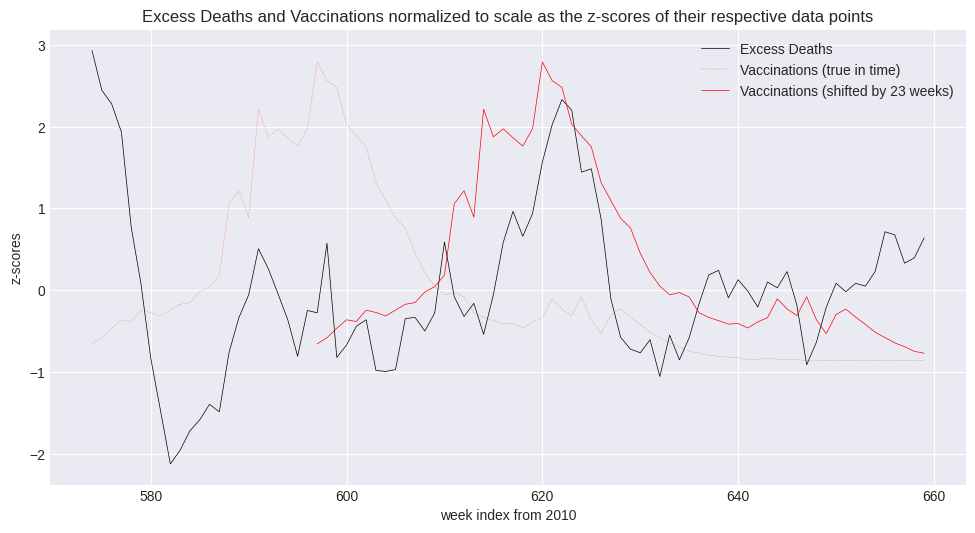

In [98]:
# plot mortality, vaccinations and excess mortality by z-score

# define size of plot
cm = 1/2.54  # centimeters in inches
plt.subplots(figsize=(30*cm, 15*cm))

# define the plot

plt.title('Excess Deaths and Vaccinations normalized to scale as the z-scores of their respective data points')

ax1 = plt.subplot()
#weeks_since_2010 = death_vax_weekly["week_index"]
total_excess_z = death_vax_weekly["total_excess_z"]
impfungen_biontech_min1_gi_z = death_vax_weekly["impfungen_biontech_min1_gi_z"]
impfungen_biontech_min1_gi_z_lag = death_vax_weekly["impfungen_biontech_min1_gi_z_lag"]
#total_deaths = death_vax_weekly["total_z"]


l1, = ax1.plot(x, total_excess_z, color = 'black', linewidth = 0.5)
l2, = ax1.plot(x, impfungen_biontech_min1_gi_z, color = 'red', linewidth = 0.25, linestyle = ':')
l3, = ax1.plot(x, impfungen_biontech_min1_gi_z_lag, color = 'red', linewidth = 0.5)

ax1.set_xlabel('week index from 2010')
ax1.set_ylabel('z-scores')

plt.legend([l1, l2, l3], ["Excess Deaths", "Vaccinations (true in time)", "Vaccinations (shifted by 23 weeks)"])

plt.show()

The data for all deaths over all age groups and all vaccinations looks not very conclusive.
Let's take the age cohort between 30 and 60 and only the first vaccinations.

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 86 and the array at index 1 has size 1

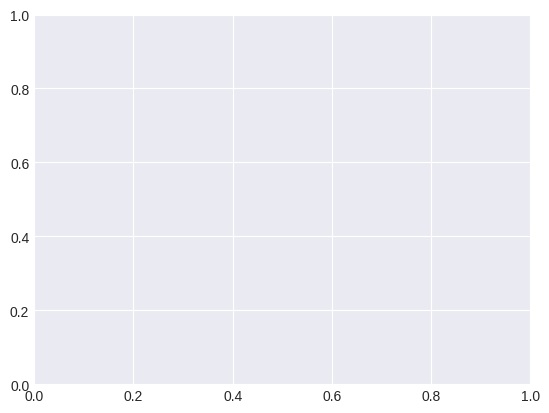

In [68]:
# plot the vaccination campaigns as stacked area chart

# Create data
x=death_vax_weekly["week_index"]
y1=death_vax_weekly["impfungen_biontech_min1"]
y2=death_vax_weekly["impfungen_biontech_gi"]
y3=death_vax_weekly["impfungen_biontech_boost1"]
y4=death_vax_weekly["impfungen_biontech_boost2"]

# Basic stacked area chart.
plt.stackplot(x,y1, y2, y3, y4, labels=['at least one shot','second shot','booster 1','booster 2'])
plt.legend(loc='upper left')
